In [1]:
from tqdm import tqdm
import torch

import torch_scatter
import torch_geometric

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


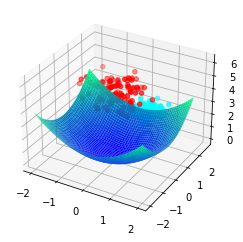

In [2]:
# show some 3d-point cloud data.
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

fig = plt.figure()
ax = plt.axes(projection = '3d')

scale = 2
x = torch.linspace(-1, 1, 100) * scale
y = torch.linspace(-1, 1, 100) * scale
X,Y = torch.meshgrid(x,y)
Z = X**2 + Y**2 

#ax.plot_surface(X,Y,Z, cmap = "rainbow")

ax.plot_surface(X,Y,Z * 0.5, cmap = "winter")

N = 100
x_points = torch.randn([N, 3]) * 0.5 + torch.tensor([-0.,-0,5]).unsqueeze(0).repeat([N,1])
y_points = torch.randn([N, 3]) * 0.3 + torch.tensor([0.2,2,2]).unsqueeze(0).repeat([N,1])


ax.scatter(x_points[:,0], x_points[:,1], x_points[:,2], color = "red")
ax.scatter(y_points[:,0], y_points[:,1], y_points[:,2], color = "cyan")

plt.show()


/var/folders/tp/c2bzzvd17y35z8x_20mfhn700000gn/T/ipykernel_83472/2308678624.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


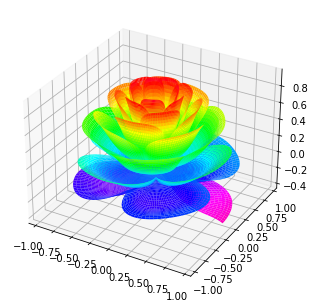

In [3]:
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm

from matplotlib.ticker import LinearLocator

import matplotlib.pyplot as plt

import numpy as np

fig=plt.figure()

ax=Axes3D(fig)
#ax = axes3d.Axes3D(fig)

[x,t]=np.meshgrid(np.array(range(25))/24.0,np.arange(0,575.5,0.5)/575*17*np.pi-2*np.pi)

p=(np.pi/2)*np.exp(-t/(8*np.pi))

u=1-(1-np.mod(3.6*t,2*np.pi)/np.pi)**4/2

y=2*(x**2-x)**2*np.sin(p)

r=u*(x*np.sin(p)+y*np.cos(p))

surf=ax.plot_surface(r*np.cos(t),r*np.sin(t),u*(x*np.cos(p)-y*np.sin(p)),rstride=1,cstride=1,cmap=cm.gist_rainbow_r,

                  linewidth=0,antialiased=True)

plt.show()


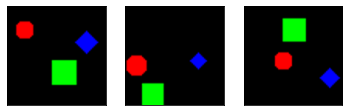

In [40]:
from datasets import *
from models import *
from config import *

node_feat_size = 64
graph_prop_iters = 7
GraphPropagation(num_iters = graph_prop_iters)

grid_convs = RDN(SimpleNamespace(G0=node_feat_size  ,RDNkSize=3,n_colors=3,
                               RDNconfig=(4,3,16),scale=[2],no_upsampling=True))

test_dataset = SpriteData(split = "train")
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 3, shuffle = True)

for sample in dataloader:
    ims = sample["image"]
    break;

B, W, H, C = ims.shape
# show the image data to test
plt.figure("input-data", frameon = False,)

for b in range(B):
    plt.subplot(1, B, b + 1);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False); plt.imshow(ims[b,:,:,:])
plt.show()

In [33]:
imsize = 128
perception_size = 2

# build the connection graph for the grid domain
spatial_edges, spatial_coords = grid(imsize,imsize,device=device)
spaital_edges =  build_perception(imsize,perception_size,device = device)

# flatten the image-feature and add it with the coordinate information
im_feats = grid_convs(ims.permute([0,3,1,2])) # [B,D,W,H]

coords_added_im_feats = im_feats.flatten(2,3).permute(0,2,1) # 【B, N, D】

graph_in = Batch.from_data_list([Data(x, spatial_edges)
                                                for x in coords_added_im_feats])

def l2_normalize(x): return torch.nn.functional.normalize(x, p=2.0, dim = -1, eps = 1e-6)

def reduce_max(x, dim, keepdim = True): return torch.max(x, dim = dim, keepdim = keepdim)[0]


        # [Affinity decoder]
        self.feat_conv = nn.Conv2d(output_dim, kq_dim, kernel_size=1, bias=True, padding='same')
        self.key_proj = nn.Linear(kq_dim, kq_dim)
        self.query_proj = nn.Linear(kq_dim, kq_dim)

        # [Affinity sampling]
        self.sample_affinity = subsample_affinity and (not (eval_full_affinity and (not self.training)))
        for level in range(supervision_level):
            stride = 2 ** level
            H, W = affinity_res[0]//stride, affinity_res[1]//stride
            buffer_name = f'local_indices_{H}_{W}'
            self.register_buffer(buffer_name, utils.generate_local_indices(img_size=[H, W], K=local_window_size).cuda(), persistent=False)


In [42]:
# prototype for the construct quarter
class ConstructQuarter(nn.Module):
    def __init__(self, k_nodes = 5):
        super().__init__()
        # [Graph Convolution] for the input data
        self.graph_conv = nn.Sequential([])
        self.location_itrs = 10

        # [Graph Propagation] create the Graph Propgation Module
        self.graph_propagator = GraphPropagation(num_iters = 7)

        # [Node Extraction]
        self.node_extractor = NodeExtraction(k_nodes = k_nodes)

        # [Affinity Decoder] softversion of graph constructer
        self.edge_predicter = None
        

    def forward(self, x, edge_affinities):
        # abstract the input graph data
        abstract_features = self.graph_conv(x, edge_affinities)
        # perform propagation over the continuous label on the graph
        prop_features = self.graph_propagator(abstract_features, edge_affinities)[-1]

        # region competition and constuct the nodes at each level.
        masks_extracted = []
        for i in range(self.location_itrs):
            i
        return x, edge_affinities

In [ ]:
# [Scene Structure]
class SceneStructure:
    def __init__(self, features, scores, edge_affinities, from_base = None, base = None):
        self.features = features # [N, D]
        self.scores   = scores # [N, 1]
        self.edge_affinities = edge_affinities # [N, N]
        self.from_base = from_base # [2,N]: [[1, 3],[1, 1]]
        self.to_base = from_base
        self.base = base # Base Level Scene Structure
    
    def is_base(self): return self.from_base is None

    def compute_mask(self, indices): 
        # input: indices of nodes that need to compute mask
        if self.is_base():
            # this is the base level, just return the corresponding nodes
            pass
        return 
        

In [44]:
# may be we need a new graph propagation module

class GraphPropagator(nn.Module):
    def __init__(self, iters = 10):
        super().__init__()

In [41]:
class GraphAttention(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
    
    def forward(x, affinity_matrix):
        # [N,N]
        return 0

In [ ]:
class NodeExtraction(nn.Module):
    def __init__(self, k_nodes = 5):
        super().__init__()

    def forward(self,x):
        return x

In [79]:
propagator = GraphPropagation(num_iters = 4)

node_features = torch.randn([B, N, 64])
affinities = torch.randn([B, N, N, 1]) ** 2

outputs = propagator(node_features, affinities)

for plateau in outputs:pass


def sparse2affinities(sparse_edges, weights = None):
    num_nodes = sparse_edges.max() + 1
    affinities = torch.zeros([1, num_nodes, num_nodes])
    return affinities

def affinities2sparse(affinities, graph_batch):
    edge_attr = []
    return 0

# create the test graph
batch = 2
x = torch.randn([batch, 3, 32])
edges = torch.tensor([[1,2], [0,2], [0,1]])
print(x.shape, edges.t().shape)
# create the input graph structure
graph_in = Batch.from_data_list(
    [Data(x_, edges.t(), edge_attr = torch.ones_like(edges.t()))  for x_ in x ])

print(graph_in.x.shape)
print(graph_in.edge_stores[0]["edge_index"])
print(graph_in.edge_stores[0]["edge_attr"])


affinities = sparse2affinities(edges)
print(affinities.shape)

torch.Size([2, 3, 32]) torch.Size([2, 3])
torch.Size([6, 32])
tensor([[1, 0, 0, 4, 3, 3],
        [2, 2, 1, 5, 5, 4]])
tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])
torch.Size([1, 3, 3])
